# Load required libraries

In [ ]:
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras import Sequential, Model, optimizers, losses,Input
from tensorflow.keras import layers
from tensorflow.keras import utils
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
# from tensorflow.keras.applications.resnet50 import preprocess_input,ResNet50
# from tensorflow.keras.applications.inception_v3 import InceptionV3
import scipy.ndimage
from skimage.transform import resize
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.model_selection import train_test_split
#from tensorflow.keras.applications.resnet50 import preprocess_input


# Load the training data

In [ ]:
(x_train, y_train), (_, __) = load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
x_train.shape

(50000, 32, 32, 3)

# Visualising the data

# Take random 5 images from each class for visualisation

In [ ]:
indices = {cls: np.random.choice(np.where(y_train == cls)[0], 5, replace=False) for cls in range(10)}

In [ ]:
indices

{0: array([14080, 46613, 40851, 13260, 16423]),
 1: array([ 4917, 41322, 26789,  3142, 13366]),
 2: array([ 6757, 38806, 39308, 48232,  6488]),
 3: array([42408, 24775,  6493, 38246, 39651]),
 4: array([31627, 23943, 32280,  8417, 19548]),
 5: array([39456, 14673, 33820, 40373,  9196]),
 6: array([37846, 33411, 13049, 42099, 10218]),
 7: array([22703, 49116, 45724, 19542,  6449]),
 8: array([10688, 22776, 39534, 29694, 33549]),
 9: array([15420, 21121, 21583, 23979, 16614])}

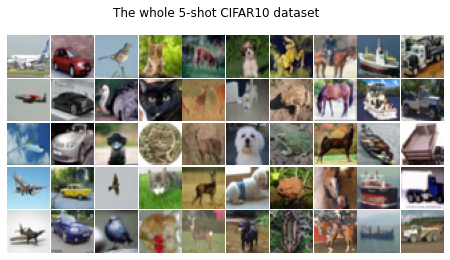

In [ ]:
fig = plt.figure(figsize=(10, 4))
ig = ImageGrid(fig, 111, (5, 10))
for c, cls in enumerate(indices):
  for r, i in enumerate(indices[cls]):
    img= x_train[i,:,:,:]
    ax = ig.axes_column[c][r]
    ax.imshow((img).astype(np.uint8))
    ax.set_axis_off()
fig.suptitle('The whole 5-shot CIFAR10 dataset');

# Let's find the distribution of each class in the CIFAR10 dataset

In [ ]:
total_indices = {cls: len(np.where(y_train == cls)[0]) for cls in range(10)}

In [ ]:
total_indices

{0: 5000,
 1: 5000,
 2: 5000,
 3: 5000,
 4: 5000,
 5: 5000,
 6: 5000,
 7: 5000,
 8: 5000,
 9: 5000}

# All the classes are equally distributed so there is no class imbalance and we can proceed further in model creation

In [ ]:
x_train=x_train.astype("float32")/np.max(x_train)


In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
num_classes=len(np.unique(y_train))

In [ ]:
y_train=utils.to_categorical(y_train,num_classes=num_classes)

# Method -1 ( Simple model)

# Creating model

In [ ]:
model=Sequential()
model.add(layers.Conv2D(32,kernel_size=(5,5),padding='same',input_shape=x_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(32,kernel_size=(5,5),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64,kernel_size=(3,3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(64,kernel_size=(3,3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))



In [ ]:
opt=optimizers.RMSprop(learning_rate=0.0001,decay=1e-6)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [ ]:
data_augmentation=True
batch_size=128
epochs=50

In [ ]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              shuffle=True,validation_split=0.1)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.1)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        workers=4)


Using real-time data augmentation.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
391/391 [==============================] - 35s 90ms/step - loss: 1.9738 - accuracy: 0.2958
Epoch 2/50
391/391 [==============================] - 36s 92ms/step - loss: 1.6459 - accuracy: 0.3986
Epoch 3/50
391/391 [==============================] - 37s 94ms/step - loss: 1.5295 - accuracy: 0.4422
Epoch 4/50
391/391 [==============================] - 35s 91ms/step - loss: 1.4469 - accuracy: 0.4763
Epoch 5/50
391/391 [==============================] - 36s 91ms/step - loss: 1.3854 - accuracy: 0.5008
Epoch 6/50
391/391 [==============================] - 36s 91ms/step - loss: 1.3216 - accuracy: 0.5267
Epoch 7/50
391/391 [==============================] - 35s 91ms/step - loss: 1.2654 - accuracy: 0.5435
Epoch 8/50
391/391 [==============================] - 35s 89ms/step - loss: 1.2229 - accuracy: 0.5645
Epoch 9/50
391/391 [==============================] - 36s 91ms/step - los

# Saving the model

In [ ]:
folder_path='/content/drive/My Drive/cifar10/'

In [ ]:
model.save(folder_path+'model_1.h5')

# Reading the test-data

In [ ]:
import pandas as pd
test_data = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/cifar_image_flattened_pixels.csv")

In [ ]:
x_test=np.asarray(test_data)

In [ ]:
x_test.shape

(2000, 3072)

In [ ]:
x_test=x_test.reshape(-1,32,32,3)

In [ ]:
x_test.shape

(2000, 32, 32, 3)

In [ ]:
x_test=x_test.astype("float32")/np.max(x_test)

# Predicting the result for the model

In [ ]:
y_test=model.predict(x_test)

In [ ]:
y_test[0]

array([6.93158899e-03, 1.27422740e-04, 4.65360463e-01, 3.05994600e-01,
       4.39946949e-02, 1.41057065e-02, 1.37814134e-01, 2.04649661e-02,
       2.36569205e-03, 2.84076692e-03], dtype=float32)

In [ ]:
y_final=np.argmax(y_test,axis=1)

In [ ]:
y_final.shape

(2000,)

In [ ]:
tes
t_data['target']=y_final

In [ ]:
test_data.to_csv(folder_path+'final_data.csv',index=False)

# This model achieves accuracy of 70.6 % on the test set

# Method -2 (BITS)

This is based on the following notebook

https://github.com/google-research/big_transfer/blob/master/colabs/big_transfer_pytorch.ipynb

In [ ]:
from functools import partial
from collections import OrderedDict
%config InlineBackend.figure_format = 'retina'
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision as tv
import requests
import io
import PIL

# Reading weight data from the Cloud bucket

In [ ]:
def get_weights(bit_variant):
  response = requests.get(f'https://storage.googleapis.com/bit_models/{bit_variant}.npz')
  response.raise_for_status()
  return np.load(io.BytesIO(response.content))

In [ ]:
weights = get_weights('BiT-M-R50x1')  # You could use other variants, such as R101x3 or R152x4 here, but it is not advisable in a colab.

# Defining the architecture and loading weights

In [ ]:
class StdConv2d(nn.Conv2d):
  def forward(self, x):
    w = self.weight
    v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
    w = (w - m) / torch.sqrt(v + 1e-10)
    return F.conv2d(x, w, self.bias, self.stride, self.padding, self.dilation, self.groups)

In [ ]:
def conv3x3(cin, cout, stride=1, groups=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=3, stride=stride, padding=1, bias=bias, groups=groups)

def conv1x1(cin, cout, stride=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=1, stride=stride, padding=0, bias=bias)

In [ ]:
def tf2th(conv_weights):
  """Possibly convert HWIO to OIHW"""
  if conv_weights.ndim == 4:
    conv_weights = np.transpose(conv_weights, [3, 2, 0, 1])
  return torch.from_numpy(conv_weights)

In [ ]:
class PreActBottleneck(nn.Module):
  """
  Follows the implementation of "Identity Mappings in Deep Residual Networks" here:
  https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua

  Except it puts the stride on 3x3 conv when available.
  """
  def __init__(self, cin, cout=None, cmid=None, stride=1):
    super().__init__()
    cout = cout or cin
    cmid = cmid or cout//4

    self.gn1 = nn.GroupNorm(32, cin)
    self.conv1 = conv1x1(cin, cmid)
    self.gn2 = nn.GroupNorm(32, cmid)
    self.conv2 = conv3x3(cmid, cmid, stride)  # Original ResNetv2 has it on conv1!!
    self.gn3 = nn.GroupNorm(32, cmid)
    self.conv3 = conv1x1(cmid, cout)
    self.relu = nn.ReLU(inplace=True)

    if (stride != 1 or cin != cout):
      # Projection also with pre-activation according to paper.
      self.downsample = conv1x1(cin, cout, stride)

  def forward(self, x):
      # Conv'ed branch
      out = self.relu(self.gn1(x))

      # Residual branch
      residual = x
      if hasattr(self, 'downsample'):
          residual = self.downsample(out)

      # The first block has already applied pre-act before splitting, see Appendix.
      out = self.conv1(out)
      out = self.conv2(self.relu(self.gn2(out)))
      out = self.conv3(self.relu(self.gn3(out)))

      return out + residual

  def load_from(self, weights, prefix=''):
    with torch.no_grad():
      self.conv1.weight.copy_(tf2th(weights[prefix + 'a/standardized_conv2d/kernel']))
      self.conv2.weight.copy_(tf2th(weights[prefix + 'b/standardized_conv2d/kernel']))
      self.conv3.weight.copy_(tf2th(weights[prefix + 'c/standardized_conv2d/kernel']))
      self.gn1.weight.copy_(tf2th(weights[prefix + 'a/group_norm/gamma']))
      self.gn2.weight.copy_(tf2th(weights[prefix + 'b/group_norm/gamma']))
      self.gn3.weight.copy_(tf2th(weights[prefix + 'c/group_norm/gamma']))
      self.gn1.bias.copy_(tf2th(weights[prefix + 'a/group_norm/beta']))
      self.gn2.bias.copy_(tf2th(weights[prefix + 'b/group_norm/beta']))
      self.gn3.bias.copy_(tf2th(weights[prefix + 'c/group_norm/beta']))
      if hasattr(self, 'downsample'):
        self.downsample.weight.copy_(tf2th(weights[prefix + 'a/proj/standardized_conv2d/kernel']))
    return self

In [ ]:
class ResNetV2(nn.Module):
  BLOCK_UNITS = {
      'r50': [3, 4, 6, 3],
      'r101': [3, 4, 23, 3],
      'r152': [3, 8, 36, 3],
  }

  def __init__(self, block_units, width_factor, head_size=21843, zero_head=False):
    super().__init__()
    wf = width_factor  # shortcut 'cause we'll use it a lot.

    self.root = nn.Sequential(OrderedDict([
        ('conv', StdConv2d(3, 64*wf, kernel_size=7, stride=2, padding=3, bias=False)),
        ('padp', nn.ConstantPad2d(1, 0)),
        ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0)),
        # The following is subtly not the same!
        #('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
    ]))

    self.body = nn.Sequential(OrderedDict([
        ('block1', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin= 64*wf, cout=256*wf, cmid=64*wf))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=256*wf, cout=256*wf, cmid=64*wf)) for i in range(2, block_units[0] + 1)],
        ))),
        ('block2', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=256*wf, cout=512*wf, cmid=128*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=512*wf, cout=512*wf, cmid=128*wf)) for i in range(2, block_units[1] + 1)],
        ))),
        ('block3', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin= 512*wf, cout=1024*wf, cmid=256*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=1024*wf, cout=1024*wf, cmid=256*wf)) for i in range(2, block_units[2] + 1)],
        ))),
        ('block4', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=1024*wf, cout=2048*wf, cmid=512*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=2048*wf, cout=2048*wf, cmid=512*wf)) for i in range(2, block_units[3] + 1)],
        ))),
    ]))

    self.zero_head = zero_head
    self.head = nn.Sequential(OrderedDict([
        ('gn', nn.GroupNorm(32, 2048*wf)),
        ('relu', nn.ReLU(inplace=True)),
        ('avg', nn.AdaptiveAvgPool2d(output_size=1)),
        ('conv', nn.Conv2d(2048*wf, head_size, kernel_size=1, bias=True)),
    ]))
  
  def forward(self, x):
    x = self.head(self.body(self.root(x)))
    assert x.shape[-2:] == (1, 1)  # We should have no spatial shape left.
    return x[...,0,0]

  def load_from(self, weights, prefix='resnet/'):
    with torch.no_grad():
      self.root.conv.weight.copy_(tf2th(weights[f'{prefix}root_block/standardized_conv2d/kernel']))
      self.head.gn.weight.copy_(tf2th(weights[f'{prefix}group_norm/gamma']))
      self.head.gn.bias.copy_(tf2th(weights[f'{prefix}group_norm/beta']))
      if self.zero_head:
        nn.init.zeros_(self.head.conv.weight)
        nn.init.zeros_(self.head.conv.bias)
      else:
        self.head.conv.weight.copy_(tf2th(weights[f'{prefix}head/conv2d/kernel']))
        self.head.conv.bias.copy_(tf2th(weights[f'{prefix}head/conv2d/bias']))

      for bname, block in self.body.named_children():
        for uname, unit in block.named_children():
          unit.load_from(weights, prefix=f'{prefix}{bname}/{uname}/')
    return self

In [ ]:
weights_cifar10 = get_weights('BiT-M-R50x1-CIFAR10')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = ResNetV2(ResNetV2.BLOCK_UNITS['r50'], width_factor=1, head_size=10)  # NOTE: No new head.
model.load_from(weights_cifar10)
model.to(device)

ResNetV2(
  (root): Sequential(
    (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (padp): ConstantPad2d(padding=(1, 1, 1, 1), value=0)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (body): Sequential(
    (block1): Sequential(
      (unit01): PreActBottleneck(
        (gn1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (gn2): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (gn3): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv3): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (downsample): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (unit02): PreActBottleneck(
        (gn1): GroupNorm(32, 256, eps=1e-05, af

# We are going to predict the result with the Resnet50 with pre-trained weights

In [ ]:
import pandas as pd
test_data = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/cifar_image_flattened_pixels.csv")

In [ ]:
x_test=np.reshape(x_test,(-1,32,32,3))

In [ ]:
preprocess_eval = tv.transforms.Compose([
    tv.transforms.Resize((128, 128), interpolation=PIL.Image.BILINEAR),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
def reshape_image(img):
  x_new=torch.zeros([img.shape[0],3,128,128])
  for val in range(img.shape[0]):
    temp=PIL.Image.fromarray(img[val,:,:,:],'RGB')
    value=preprocess_eval(temp)
    x_new[val,:,:,:]=value
  return x_new

In [ ]:
x_new=reshape_image(x_test)

In [ ]:
x_new.shape

torch.Size([2000, 3, 128, 128])

In [ ]:
loader_test = torch.utils.data.DataLoader(x_new, batch_size=100, shuffle=False, num_workers=2)
model.eval()
preds = np.zeros((1,2000))
with torch.no_grad():
  for i, x in enumerate(loader_test):
      x= x.to(device)
      logits = model(x)
      _, y = torch.max(logits.data, 1)
      preds[0,i*100:(i*100)+100]=y.cpu()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
folder_path='/content/drive/My Drive/cifar10/'

In [ ]:
res = pd.DataFrame(preds[0][:]) #preditcions are nothing but the final predictions of your model on input features of your new unseen test data
res.index = test_data.index # its important for comparison. Here "test_new" is your new test dataset
res.columns = ["prediction"]
res.to_csv(folder_path+"prediction_results.csv")      # the csv file will be saved locally on the same location where this notebook is located.

# The model achieves 97.6 test accuracy when checked 

# Future directions

We can fine-tune the BITS model, add more layers for the first model proposed, train for more epochs in case of first model proposed 

The implementation of BITS in tensorflow 2.0 will be uploaded soon in my github link once I complete the work
https://github.com/VenkateshSatagopan/